In [ ]:
# 필요 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 불러오기 및 병합

train_df = pd.read_csv('train.csv')
train_df = train_df[:100000]
factory_df = pd.read_csv('factory_metadata.csv')
weather_df = pd.read_csv('weather_info.csv')

df = pd.merge(train_df, factory_df, on='factory_id', how='left')

full_df = pd.merge(df, weather_df, on=['timestamp'], how='left')
full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])
print("데이터 로드 및 병합 완료.")


데이터 로드 및 병합 완료.


In [ ]:
# 2. 결측치 확인 및 처리 (새로 추가된 섹션)
print("--- 처리 전 결측치 개수 ---")
print(full_df.isnull().sum())

# 이전 시간대의 유효한 값으로 현재 시간의 결측치를 채우는 방법입니다.
full_df = full_df.fillna(method='ffill')

# ffill로도 채워지지 않는 맨 앞쪽 데이터들은 'Backward Fill'로 채웁니다.
full_df = full_df.fillna(method='bfill')

print("\n--- 처리 후 결측치 개수 ---")
print(full_df.isnull().sum())
print("\n결측치 처리 완료.\n")

--- 처리 전 결측치 개수 ---
factory_id              0
timestamp               0
target                  0
location_id_x           0
usage                   0
square_meter            0
year_built         829313
floor_count       1171785
location_id_y           0
temperature             0
cloud              848490
dewpoint                0
rain               538906
pressure           172237
wind_direction      48591
wind_speed              0
dtype: int64

--- 처리 후 결측치 개수 ---
factory_id        0
timestamp         0
target            0
location_id_x     0
usage             0
square_meter      0
year_built        0
floor_count       0
location_id_y     0
temperature       0
cloud             0
dewpoint          0
rain              0
pressure          0
wind_direction    0
wind_speed        0
dtype: int64

결측치 처리 완료.



In [ ]:
# 4. 데이터 분할 및 스케일링
print("## 4. 데이터 분할 및 스케일링\n")

# -- 시간 순서에 따른 데이터 분할 --
df_sorted = full_df.sort_values(by='timestamp').reset_index(drop=True)
split_point = int(len(df_sorted) * 0.8)
train = df_sorted.iloc[:split_point]
val = df_sorted.iloc[split_point:]

# drop할 컬럼 목록을 명확히 합니다.
drop_cols = ['timestamp', 'target_class']
X_train = train.drop(columns=drop_cols, errors='ignore')
y_train = train['target_class']
X_val = val.drop(columns=drop_cols, errors='ignore')
y_val = val['target_class']

print(f"학습 데이터: {X_train.shape}, 검증 데이터: {X_val.shape}\n")

# -- 피처 스케일링 (로지스틱 회귀를 위해) --
numeric_cols = X_train.select_dtypes(include=np.number).columns
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

X_val_scaled = X_val.copy()
X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])

## 4. 데이터 분할 및 스케일링

학습 데이터: (1242243, 17), 검증 데이터: (310561, 17)



In [ ]:
# 5. 모델링

# -- 모델 1: 로지스틱 회귀 --
# 스케일링된 데이터를 사용하여 학습합니다.
print("로지스틱 회귀 모델 학습 시작...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
print("학습 완료.")

# -- 모델 2: XGBoost --
print("\nXGBoost 모델 학습 시작...")
X_train_xgb = X_train.copy()
X_val_xgb = X_val.copy()
# 실제 범주형 컬럼 리스트를 다시 확인합니다.
xgb_model = xgb.XGBClassifier(random_state=42,
                              enable_categorical=True, # category 타입 피처를 자동으로 처리
                              early_stopping_rounds=50) # 성능 개선이 없으면 조기 종료

xgb_model.fit(X_train_xgb, y_train,
              eval_set=[(X_val_xgb, y_val)],
              verbose=False) # 학습 과정을 출력하지 않음
print("학습 완료.\n")

## 5. 모델링

로지스틱 회귀 모델 학습 시작...
학습 완료.

XGBoost 모델 학습 시작...
학습 완료.



In [22]:
# 6. 결과 분석 및 비교
# 로지스틱 회귀 예측
lr_preds = lr_model.predict(X_val_scaled)
lr_probs = lr_model.predict_proba(X_val_scaled)[:, 1]

# XGBoost 예측
xgb_preds = xgb_model.predict(X_val_xgb)
xgb_probs = xgb_model.predict_proba(X_val_xgb)[:, 1]

# -- 성능 지표 출력 --
print("--- Logistic Regression 성능 ---")
print(f"Accuracy: {accuracy_score(y_val, lr_preds):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, lr_probs):.4f}")
print("\n[Classification Report]")
print(classification_report(y_val, lr_preds, target_names=['Low (0)', 'High (1)']))

--- Logistic Regression 성능 ---
Accuracy: 0.7757
ROC AUC: 0.8532

[Classification Report]
              precision    recall  f1-score   support

     Low (0)       0.77      0.78      0.77    153141
    High (1)       0.78      0.77      0.78    157420

    accuracy                           0.78    310561
   macro avg       0.78      0.78      0.78    310561
weighted avg       0.78      0.78      0.78    310561



In [23]:
print("--- XGBoost 성능 ---")
print(f"Accuracy: {accuracy_score(y_val, xgb_preds):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, xgb_probs):.4f}")
print("\n[Classification Report]")
print(classification_report(y_val, xgb_preds, target_names=['Low (0)', 'High (1)']))

--- XGBoost 성능 ---
Accuracy: 0.9714
ROC AUC: 0.9927

[Classification Report]
              precision    recall  f1-score   support

     Low (0)       0.97      0.97      0.97    153141
    High (1)       0.97      0.97      0.97    157420

    accuracy                           0.97    310561
   macro avg       0.97      0.97      0.97    310561
weighted avg       0.97      0.97      0.97    310561



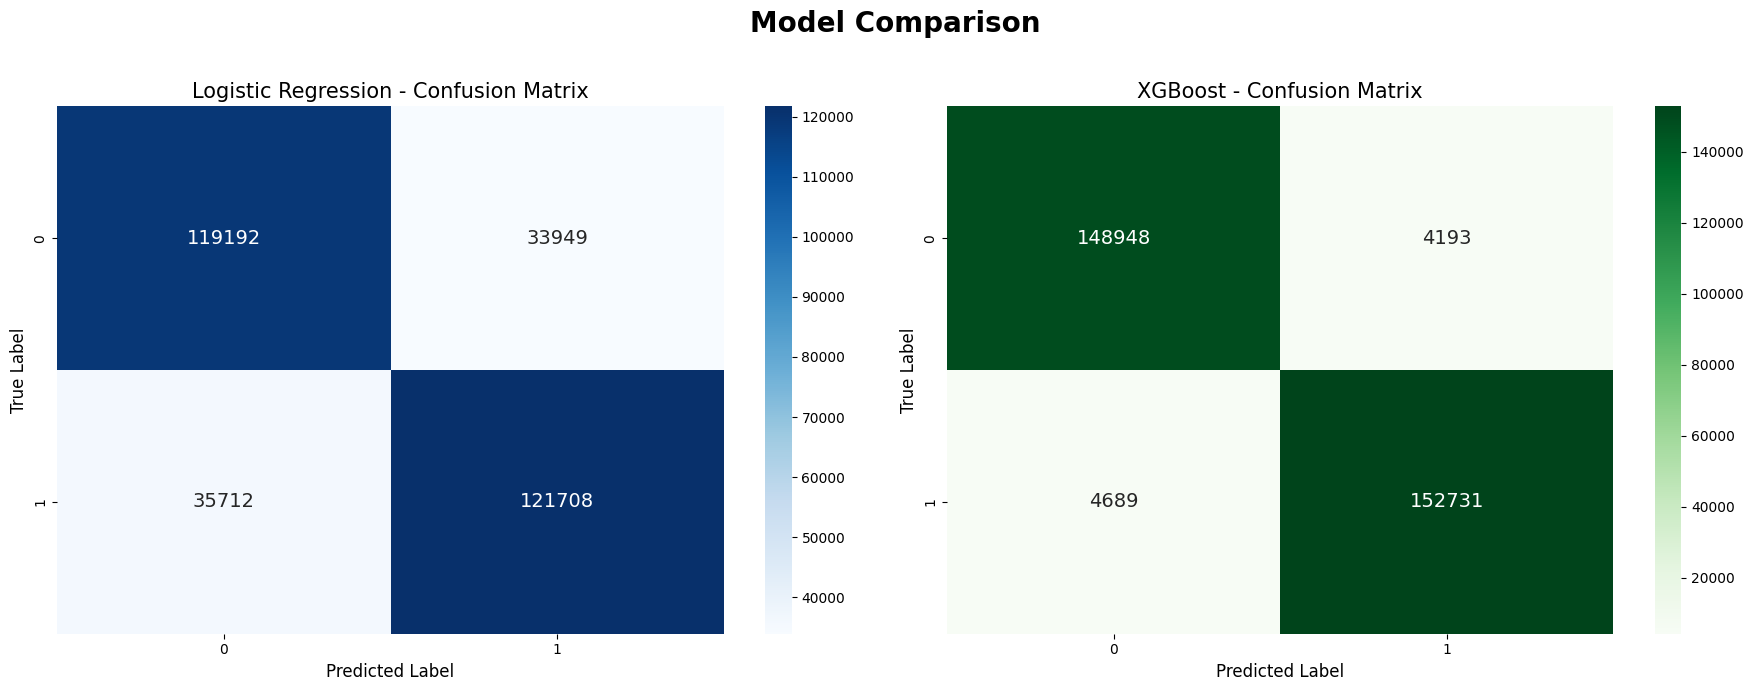

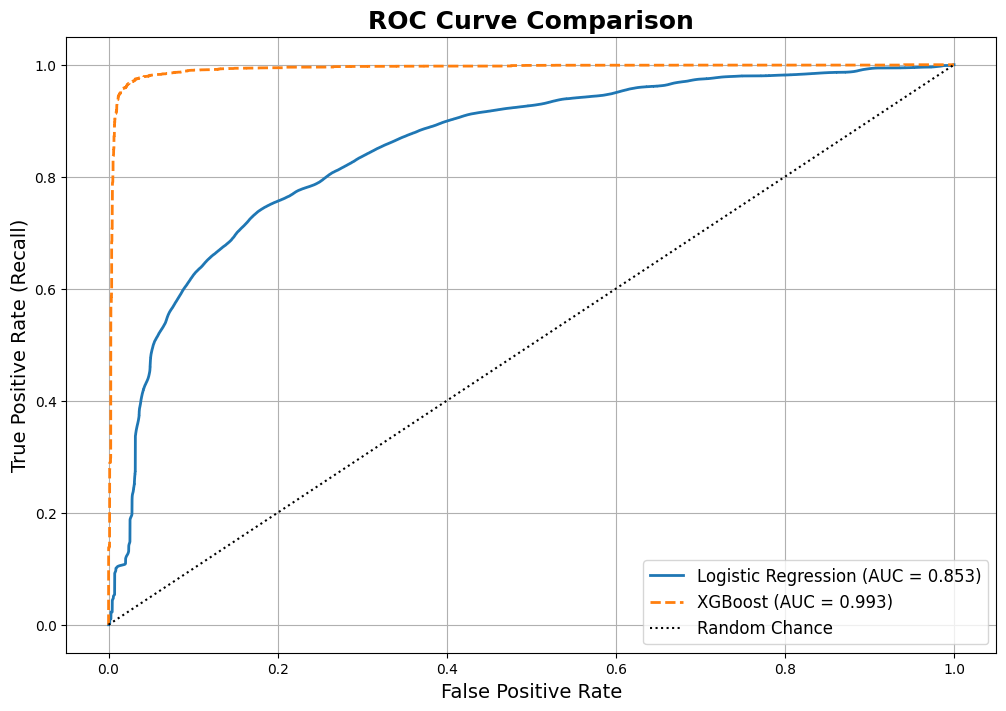

In [24]:
# -- 시각적 비교 --
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Model Comparison', fontsize=20, fontweight='bold')

# 1. 혼동 행렬 비교
sns.heatmap(confusion_matrix(y_val, lr_preds), annot=True, fmt='d', cmap='Blues', ax=axes[0], annot_kws={"size": 14})
axes[0].set_title('Logistic Regression - Confusion Matrix', fontsize=15)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

sns.heatmap(confusion_matrix(y_val, xgb_preds), annot=True, fmt='d', cmap='Greens', ax=axes[1], annot_kws={"size": 14})
axes[1].set_title('XGBoost - Confusion Matrix', fontsize=15)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 2. ROC Curve 비교
plt.figure(figsize=(12, 8))
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_val, xgb_probs)

plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_val, lr_probs):.3f})', linewidth=2)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {roc_auc_score(y_val, xgb_probs):.3f})', linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k:', label='Random Chance')

plt.title('ROC Curve Comparison', fontsize=18, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate (Recall)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()